In [1]:
import json
import requests


os.makedirs("cache", exist_ok=True)


def cached_fetch_json(url, key, skip_cache=False):
    """Download a URL and save the result in a cache"""
    cache_path = f"cache/{key}.json"
    # if in cache, return results
    if os.path.exists(cache_path) and not skip_cache:
        with open(cache_path) as f:
            return json.load(f)

    r = requests.get(url)
    r.raise_for_status()
    data = r.json()
    if data:
        with open(cache_path, "w") as f:
            f.write(r.text)
    return data

In [15]:
import datetime

import pandas as pd

first_week = (2020, 8)

# from https://www.fhi.no/sv/smittsomme-sykdommer/corona/dags--og-ukerapporter/dags--og-ukerapporter-om-koronavirus/
chart_url = "https://www.fhi.no/api/chartdata/api/90990"


def collect_data():
    """Collect weekly counts by age"""
    today = datetime.date.today()
    isotoday = today.isocalendar()
    this_week = isotoday.week
    this_year = today.year
    year, week = first_week
    all_data = []
    weeks = []
    rows = []
    # don't collect this week, which is usually incomplete
    end_week = this_week if isotoday.weekday > 4 else this_week - 1
    while (year, week) < (this_year, this_week):
        year_week = f"{year}-{week:02}"
        #         print(f"Fetching {year_week}")
        sys.stdout.write(".")
        url = f"{chart_url}?yearweek={year_week}"
        week_data = cached_fetch_json(
            url,
            key=year_week,
            skip_cache=(year, week) > (this_year, this_week - 2),
        )
        if week_data:
            # looks like
            #             [
            #                 ['Alder', 'Kvinner', 'Menn'],
            #                 ['0-9', 4, 3],
            #                 ['10-19', 8, 10],
            week_int = year * 100 + week
            for row in week_data[1:]:
                # skip header
                # each row is ('age', *counts)
                # discard gender info
                rows.append(
                    (
                        datetime.datetime.fromisocalendar(year, week, 1),
                        row[0],
                        sum(row[1:]),
                    )
                )
        else:
            print(f"No data for {year}-{week}", r, r.json())
        week += 1
        if week > 52:
            # wraparound
            week = 1
            year += 1
    return pd.DataFrame(rows, columns=["week", "age", "cases"])


df = collect_data()
df

.........................................................................................

,week,age,cases
0,2020-02-17,0-9,0
1,2020-02-17,10-19,0
2,2020-02-17,20-29,1
3,2020-02-17,30-39,0
4,2020-02-17,40-49,0
...,...,...,...
885,2021-11-01,50-59,821
886,2021-11-01,60-69,522
887,2021-11-01,70-79,368
888,2021-11-01,80-89,170


Fetch demographic data for Norway's population by age

In [16]:
# from https://www.ssb.no/en/statbank/table/07459/tableViewLayout1/
ssb_pop_url = "https://data.ssb.no/api/v0/en/table/07459/"
ssb_pop_query = {
    "query": [
        {"code": "Region", "selection": {"filter": "vs:Landet", "values": []}},
        {
            "code": "Alder",
            "selection": {
                "filter": "agg:TiAarigGruppering",
                "values": [
                    "F00-09",
                    "F10-19",
                    "F20-29",
                    "F30-39",
                    "F40-49",
                    "F50-59",
                    "F60-69",
                    "F70-79",
                    "F80-89",
                    "F90-99",
                    "F100G10+",
                ],
            },
        },
        {"code": "Tid", "selection": {"filter": "item", "values": ["2021"]}},
    ],
    "response": {"format": "json-stat2"},
}

r = requests.post(ssb_pop_url, data=json.dumps(ssb_pop_query))
from pyjstat import pyjstat
pop_by_age = pyjstat.Dataset.read(r.text).write('dataframe')
pop_by_age

# merge 90-99 and 100+ into 90+
pop_by_age.loc[9, ['value']] += pop_by_age.loc[10, ['value']]
pop_by_age = pop_by_age.drop(10)
pop_by_age

,age,contents,year,value
0,0-9 years,Persons,2021,593533
1,10-19 years,Persons,2021,644257
2,20-29 years,Persons,2021,705307
3,30-39 years,Persons,2021,739124
4,40-49 years,Persons,2021,719591
5,50-59 years,Persons,2021,714163
6,60-69 years,Persons,2021,588519
7,70-79 years,Persons,2021,450468
8,80-89 years,Persons,2021,190309
9,90-99 years,Persons,2021,46098


In [17]:
pop_by_age['age'] = pop_by_age.age.str.replace("-99", "+").str.split().str[0]
pop_by_age['pop fraction'] = pop_by_age.value / pop_by_age.value.sum()
pop_by_age = pop_by_age.rename(columns={"value": "population"})
pop_by_age

,age,contents,year,population,pop fraction
0,0-9,Persons,2021,593533,0.110089
1,10-19,Persons,2021,644257,0.119498
2,20-29,Persons,2021,705307,0.130822
3,30-39,Persons,2021,739124,0.137094
4,40-49,Persons,2021,719591,0.133471
5,50-59,Persons,2021,714163,0.132464
6,60-69,Persons,2021,588519,0.109159
7,70-79,Persons,2021,450468,0.083554
8,80-89,Persons,2021,190309,0.035299
9,90+,Persons,2021,46098,0.008550


In [18]:
df.age

0        0-9
1      10-19
2      20-29
3      30-39
4      40-49
       ...  
885    50-59
886    60-69
887    70-79
888    80-89
889      90+
Name: age, Length: 890, dtype: object

<AxesSubplot:xlabel='age'>

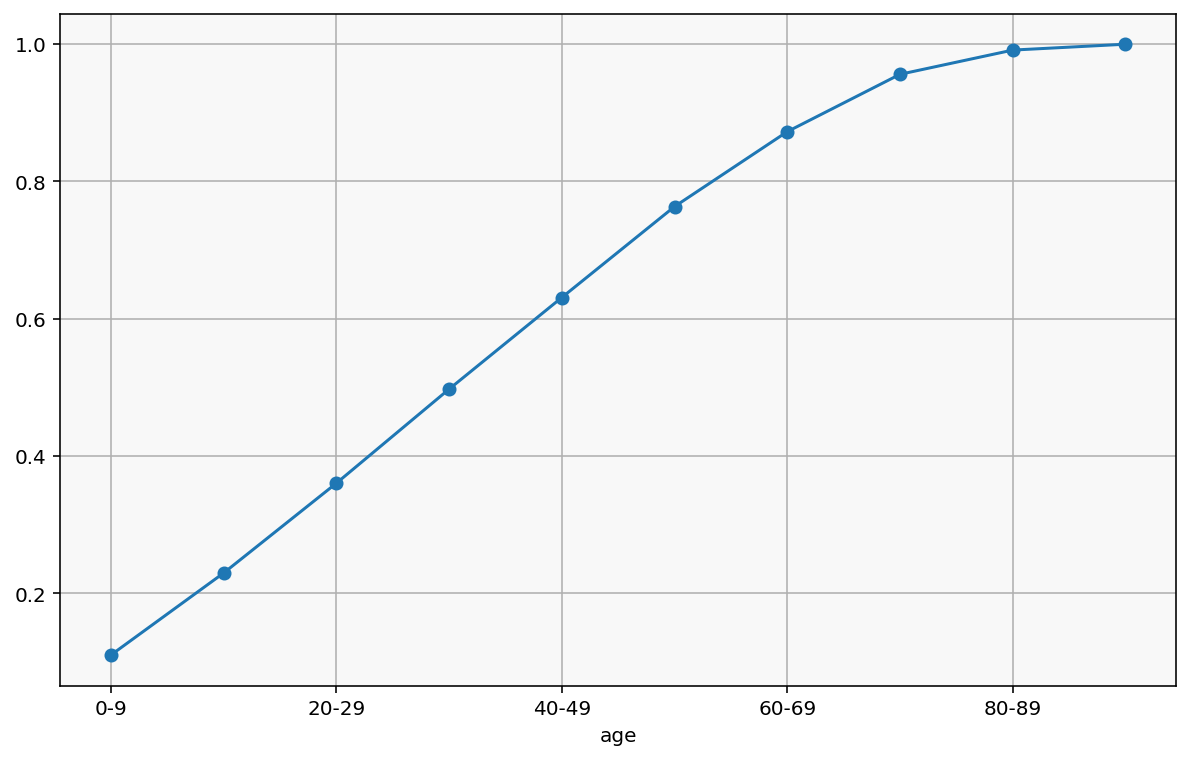

In [29]:
pop_by_age.set_index("age")["pop fraction"].cumsum().plot(style="-o")

In [19]:
pop_by_age.age

0      0-9
1    10-19
2    20-29
3    30-39
4    40-49
5    50-59
6    60-69
7    70-79
8    80-89
9      90+
Name: age, dtype: object

In [20]:
df = df.merge(pop_by_age[["age", "population", "pop fraction"]], on=["age"])
df["per100k"] = df.cases / (1e-5 * df.population)
df

,week,age,cases,population,pop fraction,per100k
0,2020-02-17,0-9,0,593533,0.110089,0.000000
1,2020-02-24,0-9,0,593533,0.110089,0.000000
2,2020-03-02,0-9,7,593533,0.110089,1.179378
3,2020-03-09,0-9,9,593533,0.110089,1.516344
4,2020-03-16,0-9,11,593533,0.110089,1.853309
...,...,...,...,...,...,...
885,2021-10-04,90+,17,46098,0.008550,36.877956
886,2021-10-11,90+,9,46098,0.008550,19.523624
887,2021-10-18,90+,36,46098,0.008550,78.094494
888,2021-10-25,90+,50,46098,0.008550,108.464575


In [23]:
import altair as alt

selection = alt.selection_multi(fields=["age"])
color = alt.condition(selection, alt.Color("age:N"), alt.value("lightgray"))
common = (
    alt.Chart(df)
    .transform_aggregate(count="sum(cases)", per100="sum(per100k)", pf="max(pop fraction)", groupby=["age", "week"])
    .transform_joinaggregate(total="sum(count)", groupby=["week"])
    .transform_calculate(frac=alt.datum.count / alt.datum.total)
    # .transform_calculate(pf=alt.datum["pop fraction"])

)

encodings = dict(
    x="week",
    y=alt.Y("per100:Q", title="Cases (per 100k)"),
    color=color,
    tooltip=[
        "week",
        "age",
        alt.Tooltip("total:Q", title="Total weekly cases"),
        alt.Tooltip("count:Q", title="Cases by age"),
        alt.Tooltip("per100:Q", title="Cases by age (per 100k)", format=".0f"),
        alt.Tooltip("frac:Q", title="Fraction of cases by age", format=".0%"),
        alt.Tooltip("pf:Q", title="Fraction of population by age", format=".0%"),

    ],
    order=alt.Order("age", sort="ascending"),
)
absolute = common.mark_line().encode(**encodings).interactive()


total_encodings = {}
total_encodings.update(encodings)
total_encodings.update(dict(y=alt.Y("total:Q", tooltip=["total:Q"])))

#absolute |= common.mark_line().encode(**total_encodings).interactive()
encodings.update(dict(y=alt.Y("count:Q", title="Fraction", stack="normalize")))
fraction = common.mark_area().encode(**encodings)
(absolute | fraction).add_selection(selection)

alt.HConcatChart(...)